## データセンターの帯域幅使用量を予測する

In [55]:
from typing import Union
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm.auto import tqdm

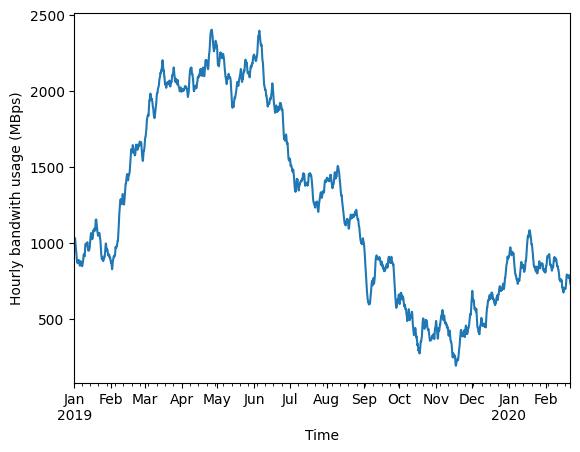

In [7]:
url = 'https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingInPython/master/data/bandwidth.csv'
df = pd.read_csv(url)
df.index = pd.date_range('2019-01-01', freq='H', periods=10000, name='Time')

# plot
fig, ax = plt.subplots()
ax.set_ylabel('Hourly bandwith usage (MBps)')
df['hourly_bandwidth'].plot(ax=ax)
plt.show()

## 自己回帰移動平均(ARMA)プロセスを調べる

## 定常的なARMAプロセスを特定する

$$
y_t = 0.33 y_{t-1} + 0.9 \varepsilon_{t-1} + \varepsilon_{t}
$$

In [29]:
ar1 = np.array([1, -0.33])
ma1 = np.array([1, 0.9])
ARMA_1_1 = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)

ADF Statistic: -7.272
p-value: 0.000


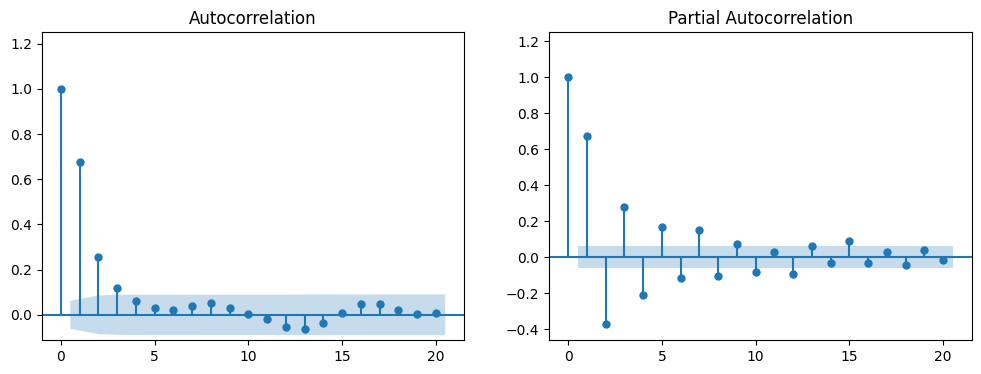

In [30]:
ADF_result = adfuller(ARMA_1_1)
print(f'ADF Statistic: {ADF_result[0]:.3f}')
print(f'p-value: {ADF_result[1]:.3f}')

# plot correlation
fig, axes = plt.subplots(1, 2, figsize=[12, 4])
plot_acf(ARMA_1_1, auto_ylims=True, lags=20, ax=axes[0])
plot_pacf(ARMA_1_1, auto_ylims=True, lags=20, ax=axes[1])
plt.show()

## 一般的なモデル化手続きを考え出す

In [31]:
# 一意なARMA(p,q)モデルをすべて適合させる関数
def optimize_ARMA(endog: Union[pd.Series, list], orders: list) -> pd.DataFrame:
    """
    endog: 時系列データ
    orders: ARMA(p,q)のpとqの値の組み合わせ
    """
    res = []
    for order in tqdm(orders):
        try:
            model = SARIMAX(
                endog, 
                order=(order[0], 0, order[1]),
                simple_differencing=False
            ).fit(disp=False)
            res.append([order, model.aic])
        except:
            continue
    df_res = (
        pd.DataFrame(res, columns=['(p,q)', 'AIC'])
        .sort_values(by='AIC', ascending=True)
        .reset_index(drop=True)
    )
    return df_res

In [34]:
orders = list(product(range(4), range(4))) # p,qをそれぞれ0~3まで動かす
df_res = optimize_ARMA(ARMA_1_1, orders)
df_res # きちんと(1,1)が最小になるようにするにはサンプルを何度か取り直す必要があった

  0%|          | 0/16 [00:00<?, ?it/s]

/home/yoneda/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/yoneda/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/yoneda/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,"(p,q)",AIC
0,"(1, 1)",2885.741227
1,"(1, 2)",2885.751142
2,"(2, 1)",2885.850308
3,"(3, 3)",2886.939561
4,"(2, 2)",2887.697220
5,"(1, 3)",2887.716314
6,"(3, 1)",2887.766068
7,"(0, 3)",2889.256964
8,"(2, 3)",2889.479302
9,"(3, 2)",2889.482391


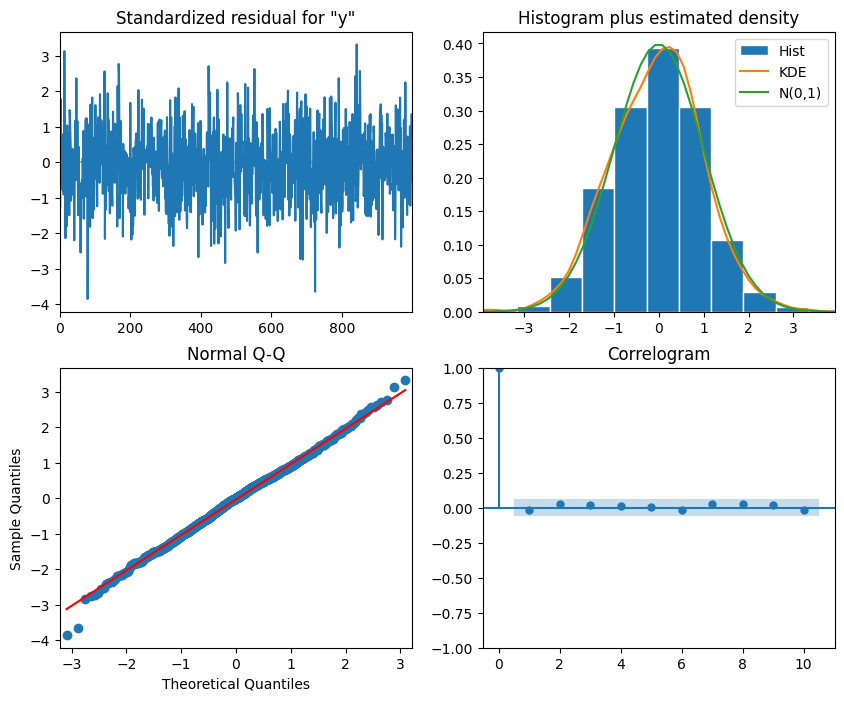

In [38]:
# 残差分析
model = SARIMAX(ARMA_1_1, order=(1, 0, 1), simple_differencing=False).fit(disp=False)
model.plot_diagnostics(figsize=(10, 8))
plt.show()

In [39]:
# 残差が無相関かの評価
acorr_ljungbox(model.resid, np.arange(1, 11))

,lb_stat,lb_pvalue
1,0.186490,0.665854
2,0.937239,0.625866
3,1.377764,0.710755
4,1.509072,0.825033
5,1.588792,0.902601
6,1.805598,0.936681
7,2.344775,0.938325
8,3.196253,0.921445
9,3.475567,0.942430
10,3.622112,0.962789


## 一般的なモデル化手続きを適用する

帯域使用量ADF検定
ADF Statistic: -0.871
p-value: 0.797
帯域使用量(1次差分) ADF検定
ADF Statistic: -20.695
p-value: 0.000


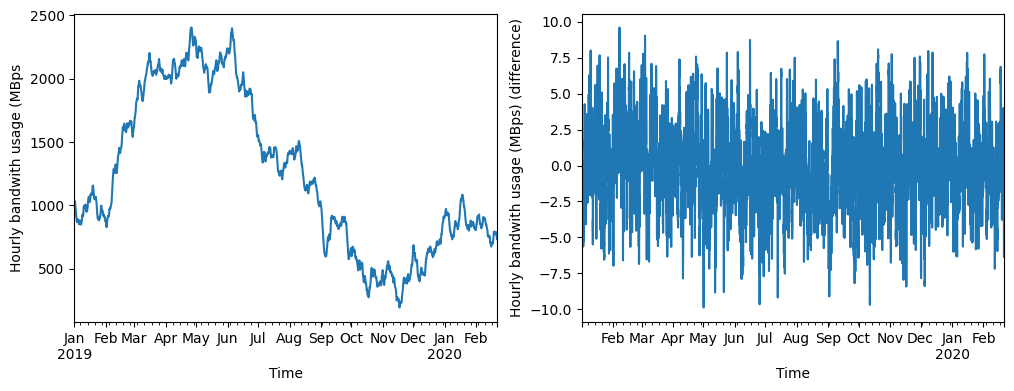

In [42]:
ADF_result = adfuller(df['hourly_bandwidth'])
print('帯域使用量ADF検定')
print(f'ADF Statistic: {ADF_result[0]:.3f}')
print(f'p-value: {ADF_result[1]:.3f}')

df_diff = df.diff().dropna()
ADF_result = adfuller(df_diff['hourly_bandwidth'])
print('帯域使用量(1次差分) ADF検定')
print(f'ADF Statistic: {ADF_result[0]:.3f}')
print(f'p-value: {ADF_result[1]:.3f}')

fig, axes = plt.subplots(1, 2, figsize=[12, 4])
df['hourly_bandwidth'].plot(ax=axes[0])
df_diff['hourly_bandwidth'].plot(ax=axes[1])
axes[0].set_ylabel('Hourly bandwith usage (MBps')
axes[1].set_ylabel('Hourly bandwith usage (MBps) (difference)')
plt.show()

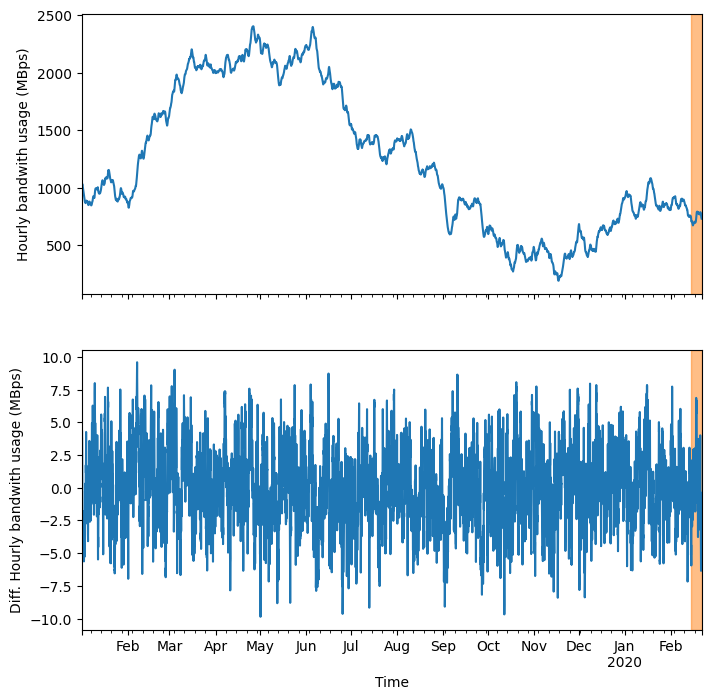

In [45]:
train = df_diff[:-168]
test = df_diff[-168:]

fig, axes = plt.subplots(2, 1, figsize=[8, 8], sharex=True)
df['hourly_bandwidth'].plot(ax=axes[0])
df_diff['hourly_bandwidth'].plot(ax=axes[1])
axes[0].set_ylabel('Hourly bandwith usage (MBps)')
axes[1].set_ylabel('Diff. Hourly bandwith usage (MBps)')
for i in range(2):
    axes[i].axvspan(test.index[0], test.index[-1], color='tab:orange', alpha=0.5)

In [48]:
optimize_ARMA(train['hourly_bandwidth'], orders)

  0%|          | 0/16 [00:00<?, ?it/s]

/home/yoneda/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/yoneda/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/yoneda/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


,"(p,q)",AIC
0,"(3, 2)",27991.063879
1,"(2, 3)",27991.287509
2,"(2, 2)",27991.603598
3,"(3, 3)",27993.416924
4,"(1, 3)",28003.349550
5,"(1, 2)",28051.351401
6,"(3, 1)",28071.155496
7,"(3, 0)",28095.618186
8,"(2, 1)",28097.250766
9,"(2, 0)",28098.407664


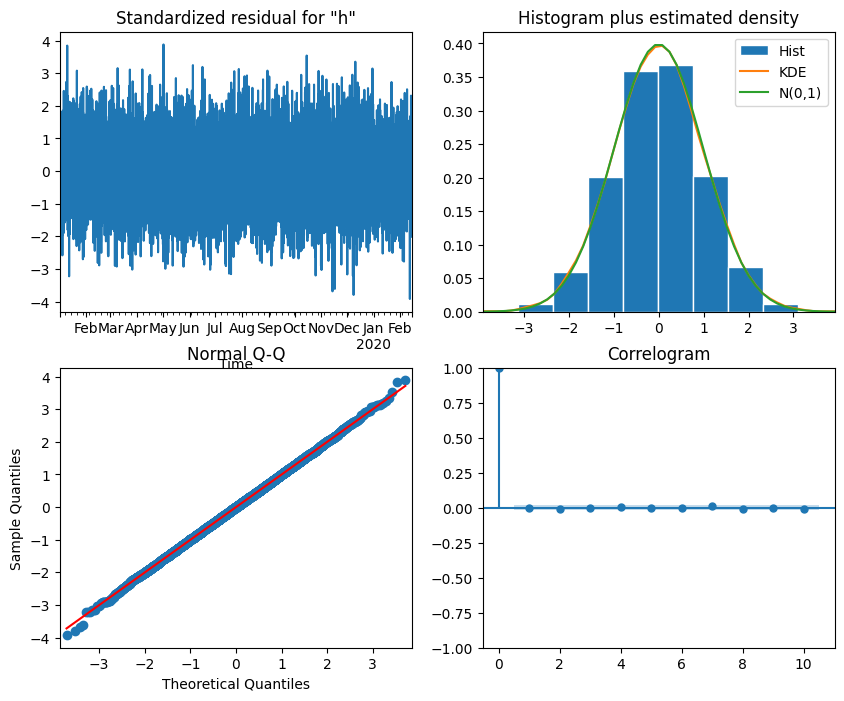

In [50]:
# 上の結果から上位3つのペアは有望そうである。
# 特に(2, 2)は変数が少ないので複雑でない。
# (2, 2)モデルの残差分析を行う
# 残差分析
model = SARIMAX(train['hourly_bandwidth'], order=(2, 0, 2), simple_differencing=False).fit(disp=False)
model.plot_diagnostics(figsize=(10, 8))
plt.show()

In [51]:
# 残差が無相関かの評価
acorr_ljungbox(model.resid, np.arange(1, 11))

,lb_stat,lb_pvalue
1,0.042190,0.837257
2,0.418364,0.811247
3,0.520271,0.914416
4,0.850554,0.931545
5,0.850841,0.973678
6,1.111754,0.981019
7,2.124864,0.952607
8,3.230558,0.919067
9,3.248662,0.953615
10,3.588289,0.964015


## 帯域幅使用量を予測する

In [52]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window :int, method: str) -> list:
    total_len = train_len + horizon
    preds = []
    if method == 'mean':
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            preds.extend(mean for _ in range(window))
    
    elif method == 'last':
        for i in range(train_len, total_len, window):
            last_val = df.iloc[i-1, 0]
            preds.extend(last_val for _ in range(window))
    
    elif method == 'ARMA':
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3, 0, 0))
            res = model.fit(disp=False)
            pred = res.get_prediction(0, i + window - 1).predicted_mean.iloc[-window:]
            preds.extend(pred)
    else:
        raise ValueError(f"Invalid method: {method}, choose from ['mean', 'last', 'ARMA']")
    return preds

In [53]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

methods = ['mean', 'last', 'ARMA']
for method in methods:
    test[method] = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, method)

/tmp/ipykernel_1070/1314583584.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[method] = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, method)
/tmp/ipykernel_1070/1314583584.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[method] = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, method)
/tmp/ipykernel_1070/1314583584.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

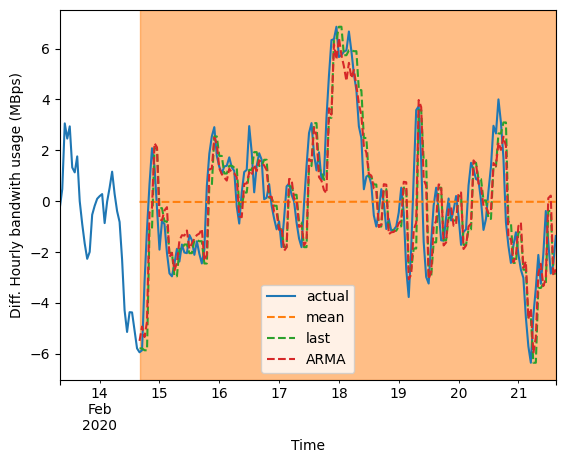

In [54]:
fig, ax = plt.subplots()
df_diff['hourly_bandwidth'].iloc[-200:].plot(ax=ax, label='actual')
ax.axvspan(test.index[0], test.index[-1], color='tab:orange', alpha=0.5)
ax.set_ylabel('Diff. Hourly bandwith usage (MBps)')
for method in methods:
    test[method].plot(ax=ax, label=method, ls='dashed')
ax.legend()
plt.show()

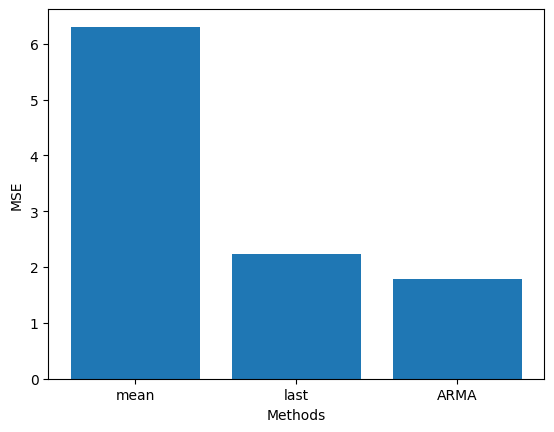

In [56]:
plt.xlabel('Methods')
plt.ylabel('MSE')
plt.bar(
    methods,
    [mean_squared_error(test['hourly_bandwidth'], test[method]) for method in methods]
)
plt.show()

/tmp/ipykernel_1070/2455051698.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_ARMA'].iloc[-168:] = df['hourly_bandwidth'].iloc[-168] + test['ARMA'].cumsum()


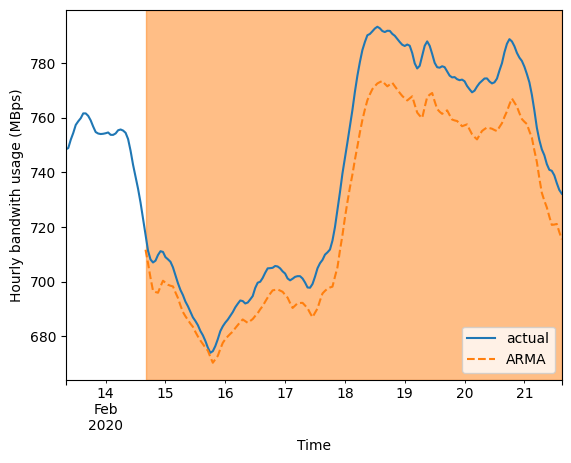

In [57]:
df['pred_ARMA'] = pd.Series()
df['pred_ARMA'].iloc[-168:] = df['hourly_bandwidth'].iloc[-168] + test['ARMA'].cumsum()

# plot
fig, ax = plt.subplots()
df['hourly_bandwidth'].iloc[-200:].plot(ax=ax, label='actual')
ax.axvspan(test.index[0], test.index[-1], color='tab:orange', alpha=0.5)
ax.set_ylabel('Hourly bandwith usage (MBps)')
df['pred_ARMA'].iloc[-200:].plot(ax=ax, label=method, ls='dashed')
ax.legend()
plt.show()

In [59]:
# calculate MAE
print(f"MAE: {mean_absolute_error(df['hourly_bandwidth'].iloc[-168:], df['pred_ARMA'].iloc[-168:]):.3f}")

MAE: 13.982
